In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
class z24Dataset(Dataset):
    def __init__(self, mode='training', window_size=100, lookahead=1, normalize=True):
        self.window_size = window_size
        self.lookahead = lookahead
        self.slices_per_file = 65536 // self.window_size
        self.normalize = normalize
        
        if mode == 'training':
            self.index_file = np.loadtxt('../tools/training_set_index.txt',dtype=str)
        elif mode == 'testing' :
            self.index_file = np.loadtxt('../tools/test_set_index.txt',dtype=str)
        elif mode == 'validating':
            self.index_file = np.loadtxt('../tools/validation_set_index.txt',dtype=str)
        
        self.name_index_dict = dict(zip(range(len(self.index_file)),list(self.index_file)))
        
        self.env_mean = np.load('../tools/env_mean.npy')
        self.env_std = np.load('../tools/env_std.npy')
        self.vibration_mean = np.load('../tools/vibration_mean.npy')
        self.vibration_std = np.load('../tools/vibration_std.npy')

    def __len__(self):
        return len(self.index_file) * self.slices_per_file

    def __getitem__(self, index):
        index_to_read = index // self.slices_per_file
        file_to_read = self.name_index_dict[index_to_read]
        index_in_dataframe = (index - index_to_read*self.slices_per_file) * self.window_size
        
        X_vibration = np.load(file='../data/z24_clean/'+file_to_read+'_vibrations.npy')
        X_environmental = np.load(file='../data/z24_clean/'+file_to_read+'_env.npy')
        
        X_vibration_window = X_vibration[index_in_dataframe:index_in_dataframe+self.window_size,:]
        Y = X_vibration[index_in_dataframe+self.window_size+1,:] 
        
        if self.normalize:
            X_vibration_window = (X_vibration_window - self.vibration_mean) / self.vibration_std
            X_environmental = (X_environmental - self.env_mean) / self.env_std
        
        return X_vibration_window, X_environmental, Y

In [3]:
test = z24Dataset(mode='training', window_size=100, lookahead=1)

In [4]:
dataloader = DataLoader(test, batch_size=2,
                        shuffle=True, num_workers=4)

In [60]:
%%time
X_vibration_batch, X_env_batch, Y_batch = next(iter(dataloader))

CPU times: user 23 ms, sys: 32 ms, total: 55 ms
Wall time: 160 ms


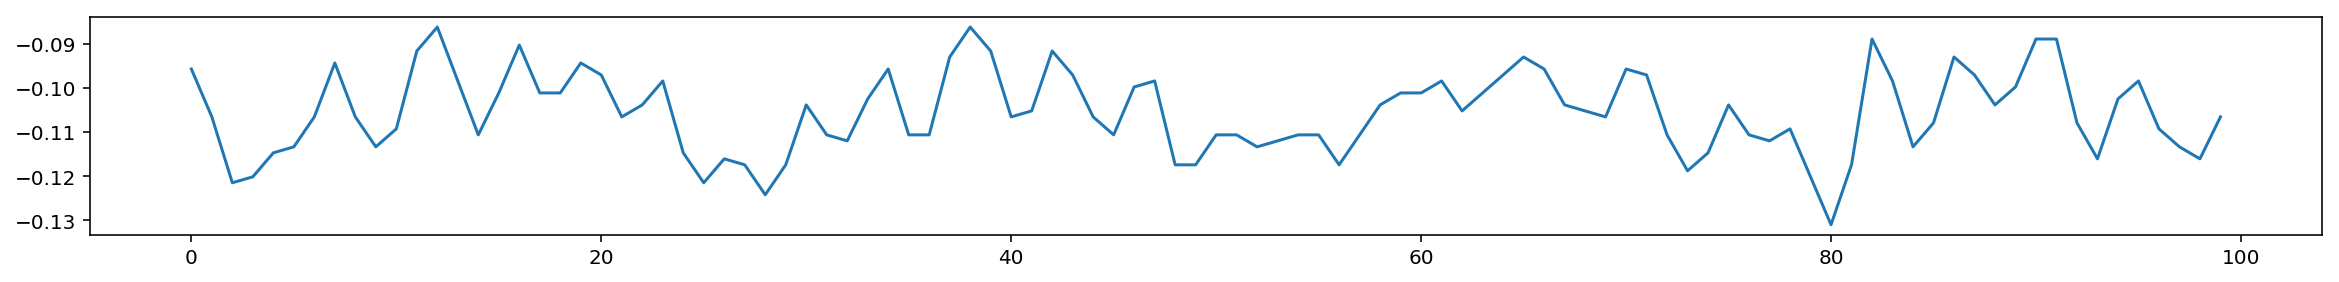

In [6]:
plt.figure(figsize=(20,2))
plt.plot(X_vibration_batch[1].numpy()[:,0])

In [119]:
class z24Dataset(Dataset):
    def __init__(self, mode='training', window_size=100, normalize=True):
        self.window_size = window_size
        self.slices_per_file = 65536 // self.window_size
        self.normalize = normalize
        
        if mode == 'training':
            self.index_file = np.loadtxt('../tools/training_set_index.txt',dtype=str)
        elif mode == 'testing' :
            self.index_file = np.loadtxt('../tools/test_set_index.txt',dtype=str)
        elif mode == 'validating':
            self.index_file = np.loadtxt('../tools/validation_set_index.txt',dtype=str)
        
        self.name_index_dict = dict(zip(range(len(self.index_file)),list(self.index_file)))
        
        self.env_mean = np.load('../tools/env_mean.npy')
        self.env_std = np.load('../tools/env_std.npy')
        self.vibration_mean = np.load('../tools/vibration_mean.npy')
        self.vibration_std = np.load('../tools/vibration_std.npy')

    def __len__(self):
        return len(self.index_file) * self.slices_per_file

    def __getitem__(self, index):
        index_to_read = index // self.slices_per_file
        file_to_read = self.name_index_dict[index_to_read]
        index_in_dataframe = (index - index_to_read*self.slices_per_file) * self.window_size
        
        file_path_vib = '../data/z24_clean/'+file_to_read+'_vibrations.npy'
        file_path_env = '../data/z24_clean/'+file_to_read+'_env.npy'
        X_vib_memmap = np.load(file='../data/z24_clean/'+file_to_read+'_vibrations.npy',mmap_mode='r')
        X_env_memmap = np.memmap(file_path_env, dtype = 'float64', mode = 'r', shape = (53, ))
        
        X_vibration_window = np.array(X_vib_memmap[index_in_dataframe:index_in_dataframe+self.window_size,:])
        X_environmental = np.array(X_env_memmap[:])

        if self.normalize:
            X_vibration_window = (X_vibration_window - self.vibration_mean) / self.vibration_std
            X_environmental = (X_environmental - self.env_mean) / self.env_std
        
        X_vib_and_env = np.append(X_vibration_window.flatten(),X_environmental)
        
        X_vibration_t = np.load(file='../data/z24_clean/'+file_to_read+'_vibrations.npy')
        X_environmental_t = np.load(file='../data/z24_clean/'+file_to_read+'_env.npy')
        X_vibration_t = X_vibration_t[index_in_dataframe:index_in_dataframe+self.window_size,:]
    
        return X_vibration_window, X_vibration_t

In [120]:
#Datasets
training_dataset = z24Dataset(mode='training', window_size=100, normalize=False)
training_dataloader = DataLoader(training_dataset, batch_size=2, shuffle=True, num_workers=4)

In [121]:
%%time
X_vibration_batch, old = next(iter(training_dataloader))



CPU times: user 29 ms, sys: 62 ms, total: 91 ms
Wall time: 358 ms


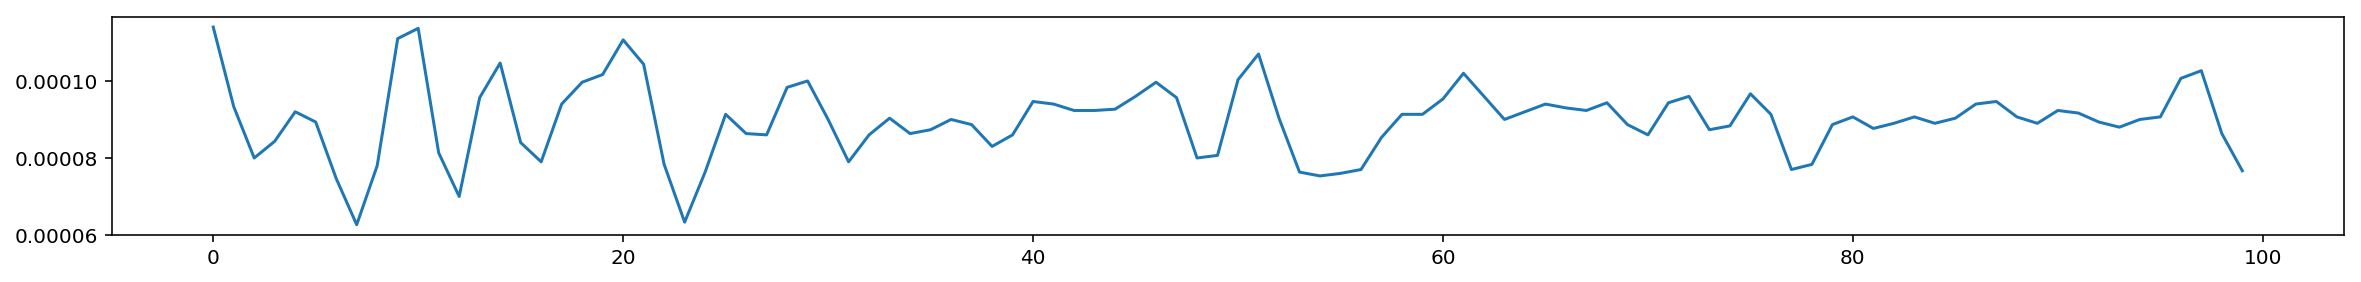

In [122]:
plt.figure(figsize=(20,2))
plt.plot(X_vibration_batch[0].detach().numpy()[:,0])

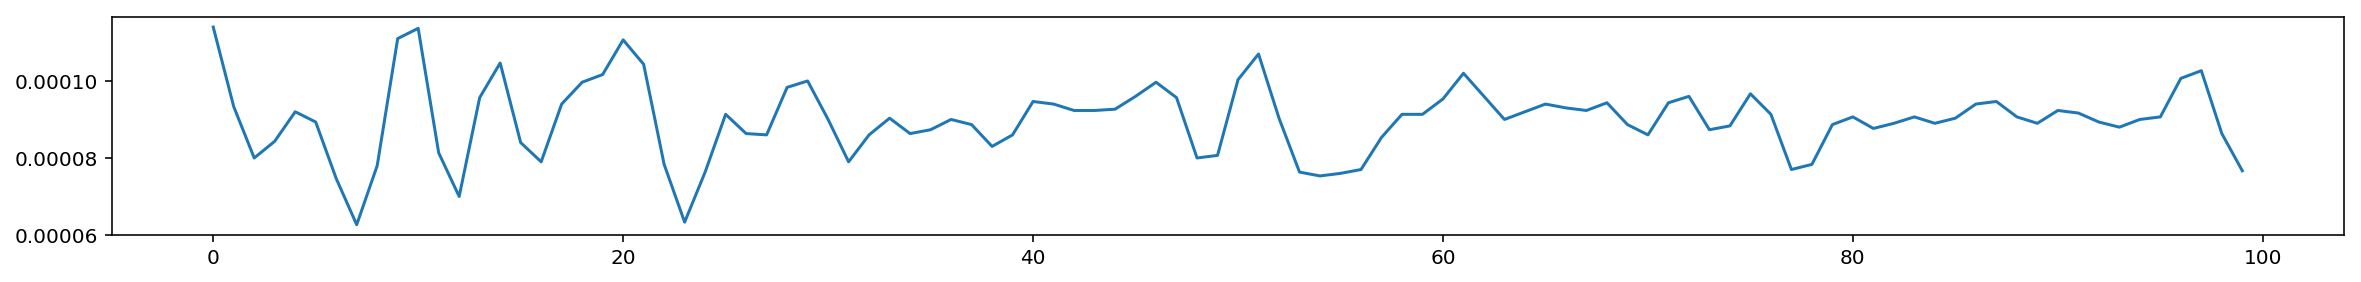

In [123]:
plt.figure(figsize=(20,2))
plt.plot(old[0].detach().numpy()[:,0])

In [99]:
%%timeit
X_vibration_t = np.load(file='../data/z24_clean/01G12_vibrations.npy',mmap_mode='r')

405 µs ± 28.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [100]:
%%timeit
X_vibration_t = np.load(file='../data/z24_clean/01G12_vibrations.npy')

2.12 ms ± 26.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [94]:
d = X_vibration_t[100:200,:]

memmap([[-1.918448e-04,  4.530000e-04, -2.466577e-03, -9.333333e-06,
          2.424413e-05, -5.400000e-05,  2.890322e-04],
        [-1.043552e-04,  4.230000e-04, -2.475009e-03,  3.333333e-07,
          8.221922e-05, -5.083333e-05,  3.744137e-04],
        [-1.243829e-04,  3.876667e-04, -1.536867e-03,  1.000000e-05,
          4.058256e-04, -4.550000e-05,  2.847104e-04],
        [-1.928989e-04,  3.590000e-04, -6.862143e-04,  1.100000e-05,
          6.577538e-04, -4.116667e-05,  1.661250e-04],
        [-2.382249e-04,  3.283333e-04, -8.527609e-04,  1.666667e-05,
          5.481281e-04, -4.333333e-05,  1.551624e-04],
        [-1.697089e-04,  2.856667e-04, -1.549516e-03,  2.766667e-05,
          2.234676e-04, -4.683333e-05,  2.014371e-04],
        [-1.075174e-04,  2.416667e-04, -1.721333e-03,  2.366667e-05,
          1.423025e-04, -4.200000e-05,  1.983802e-04],
        [-1.412484e-04,  1.970000e-04, -1.253316e-03,  1.000000e-05,
          4.469352e-04, -3.266667e-05,  1.490487e-04],
        

In [93]:
np.array(d)

array([[-1.918448e-04,  4.530000e-04, -2.466577e-03, -9.333333e-06,
         2.424413e-05, -5.400000e-05,  2.890322e-04],
       [-1.043552e-04,  4.230000e-04, -2.475009e-03,  3.333333e-07,
         8.221922e-05, -5.083333e-05,  3.744137e-04],
       [-1.243829e-04,  3.876667e-04, -1.536867e-03,  1.000000e-05,
         4.058256e-04, -4.550000e-05,  2.847104e-04],
       [-1.928989e-04,  3.590000e-04, -6.862143e-04,  1.100000e-05,
         6.577538e-04, -4.116667e-05,  1.661250e-04],
       [-2.382249e-04,  3.283333e-04, -8.527609e-04,  1.666667e-05,
         5.481281e-04, -4.333333e-05,  1.551624e-04],
       [-1.697089e-04,  2.856667e-04, -1.549516e-03,  2.766667e-05,
         2.234676e-04, -4.683333e-05,  2.014371e-04],
       [-1.075174e-04,  2.416667e-04, -1.721333e-03,  2.366667e-05,
         1.423025e-04, -4.200000e-05,  1.983802e-04],
       [-1.412484e-04,  1.970000e-04, -1.253316e-03,  1.000000e-05,
         4.469352e-04, -3.266667e-05,  1.490487e-04],
       [-1.043552e-04,  

In [5]:
class z24Dataset(Dataset):
    def __init__(self, mode='training', window_size=100, normalize=True):
        self.window_size = window_size
        self.slices_per_file = 65536 // self.window_size
        self.normalize = normalize
        
        if mode == 'training':
            self.index_file = np.loadtxt('../tools/training_set_index.txt',dtype=str)
        elif mode == 'testing' :
            self.index_file = np.loadtxt('../tools/test_set_index.txt',dtype=str)
        elif mode == 'validating':
            self.index_file = np.loadtxt('../tools/validation_set_index.txt',dtype=str)
        
        self.name_index_dict = dict(zip(range(len(self.index_file)),list(self.index_file)))
        
        self.env_mean = np.load('../tools/env_mean.npy')
        self.env_std = np.load('../tools/env_std.npy')
        self.vibration_mean = np.load('../tools/vibration_mean.npy')
        self.vibration_std = np.load('../tools/vibration_std.npy')

    def __len__(self):
        return len(self.index_file) * self.slices_per_file

    def __getitem__(self, index):
        index_to_read = index // self.slices_per_file
        file_to_read = self.name_index_dict[index_to_read]
        index_in_dataframe = (index - index_to_read*self.slices_per_file) * self.window_size
        
        file_path_vib = '../data/z24_clean/'+file_to_read+'_vibrations.npy'
        file_path_env = '../data/z24_clean/'+file_to_read+'_env.npy'
        X_vib_memmap = np.load(file_path_vib, mmap_mode='r')
        X_environmental = np.load(file_path_env)
        
        X_vibration_window = np.array(X_vib_memmap[index_in_dataframe:index_in_dataframe+self.window_size,:])

        if self.normalize:
            X_vibration_window = (X_vibration_window - self.vibration_mean) / self.vibration_std
            X_environmental = (X_environmental - self.env_mean) / self.env_std
        
        X_vib_and_env = np.append(X_vibration_window.flatten(),X_environmental)
       
        return X_vib_and_env, X_vibration_window.flatten()
    
training_dataset = z24Dataset(mode='training', window_size=100, normalize=False)
training_dataloader = DataLoader(training_dataset, batch_size=2, shuffle=True, num_workers=4)

In [6]:
%%time
for X_train, Y_train in training_dataloader:
    X_train_tensor = X_train.float().to(device)
    Y_train_tensor = Y_train.float().to(device)

OSError: Traceback (most recent call last):
  File "/home/dsteinar/miniconda3/lib/python3.6/site-packages/numpy/lib/npyio.py", line 428, in load
    return pickle.load(fid, **pickle_kwargs)
_pickle.UnpicklingError: invalid load key, '\x00'.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/dsteinar/miniconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/dsteinar/miniconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-5-8f1adc3af17f>", line 31, in __getitem__
    X_vib_memmap = np.load(file_path_vib, mmap_mode='r')
  File "/home/dsteinar/miniconda3/lib/python3.6/site-packages/numpy/lib/npyio.py", line 431, in load
    "Failed to interpret file %s as a pickle" % repr(file))
OSError: Failed to interpret file '../data/z24_clean/01E06_vibrations.npy' as a pickle


In [116]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [125]:
class z24Dataset(Dataset):
    def __init__(self, mode='training', window_size=100, normalize=True):
        self.window_size = window_size
        self.slices_per_file = 65536 // self.window_size
        self.normalize = normalize
        
        if mode == 'training':
            self.index_file = np.loadtxt('../tools/training_set_index.txt',dtype=str)
        elif mode == 'testing' :
            self.index_file = np.loadtxt('../tools/test_set_index.txt',dtype=str)
        elif mode == 'validating':
            self.index_file = np.loadtxt('../tools/validation_set_index.txt',dtype=str)
        
        self.name_index_dict = dict(zip(range(len(self.index_file)),list(self.index_file)))
        
        self.env_mean = np.load('../tools/env_mean.npy')
        self.env_std = np.load('../tools/env_std.npy')
        self.vibration_mean = np.load('../tools/vibration_mean.npy')
        self.vibration_std = np.load('../tools/vibration_std.npy')

    def __len__(self):
        return len(self.index_file) * self.slices_per_file

    def __getitem__(self, index):
        index_to_read = index // self.slices_per_file
        file_to_read = self.name_index_dict[index_to_read]
        index_in_dataframe = (index - index_to_read*self.slices_per_file) * self.window_size
        
        file_path_vib = '../data/z24_clean/'+file_to_read+'_vibrations.npy'
        file_path_env = '../data/z24_clean/'+file_to_read+'_env.npy'
        X_vib_memmap = np.load(file_path_vib, mmap_mode='r')
        X_environmental = np.load(file_path_env)
        
        X_vibration_window = np.array(X_vib_memmap[index_in_dataframe:index_in_dataframe+self.window_size,:])

        if self.normalize:
            X_vibration_window = (X_vibration_window - self.vibration_mean) / self.vibration_std
            X_environmental = (X_environmental - self.env_mean) / self.env_std
        
        X_vib_and_env = np.append(X_vibration_window.flatten(),X_environmental)
       
        return X_vib_and_env, X_vibration_window

In [135]:
#Datasets
training_dataset = z24Dataset(mode='training', window_size=100, normalize=False)
training_dataloader = DataLoader(training_dataset, batch_size=2, shuffle=True, num_workers=4)

X_vib_and_env, X_vib = next(iter(training_dataloader))


In [136]:
m = X_vib[0].detach().numpy()

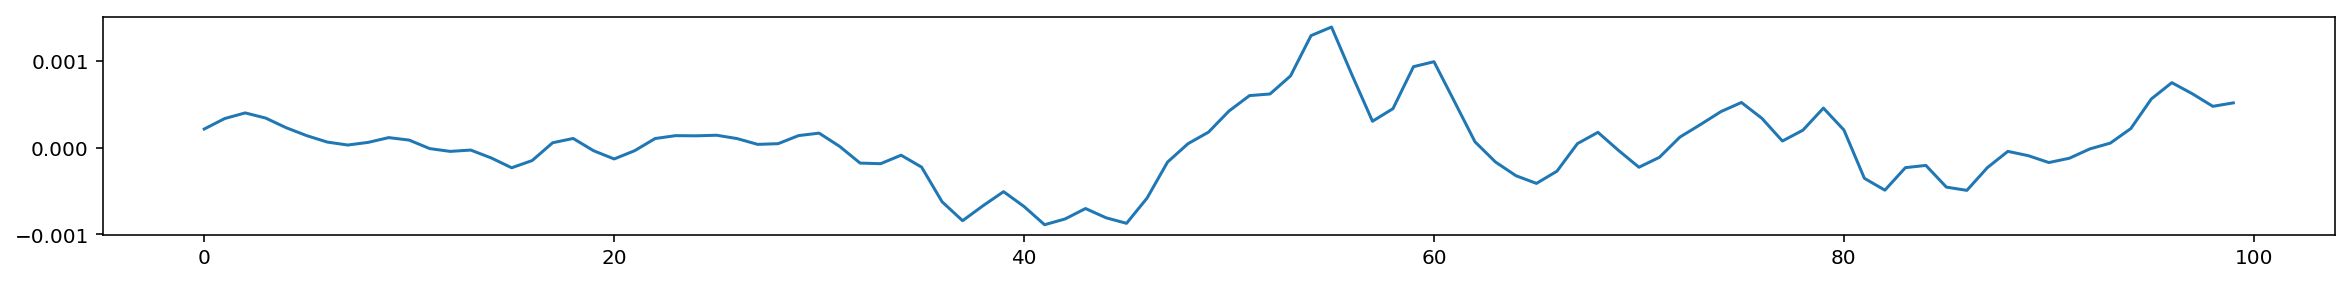

In [137]:
plt.figure(figsize=(20,2))
plt.plot(m[:,1])

In [25]:
class z24Dataset(Dataset):
    def __init__(self, mode='training', window_size=100, normalize=True):
        self.window_size = window_size
        self.slices_per_file = 65536 // self.window_size
        self.normalize = normalize
        
        if mode == 'training':
            self.index_file = np.loadtxt('../tools/training_set_index.txt',dtype=str)
        elif mode == 'testing' :
            self.index_file = np.loadtxt('../tools/test_set_index.txt',dtype=str)
        elif mode == 'validating':
            self.index_file = np.loadtxt('../tools/validation_set_index.txt',dtype=str)
        
        self.name_index_dict = dict(zip(range(len(self.index_file)),list(self.index_file)))
        
        self.env_mean = np.load('../tools/env_mean.npy')
        self.env_std = np.load('../tools/env_std.npy')
        self.vibration_mean = np.load('../tools/vibration_mean.npy')
        self.vibration_std = np.load('../tools/vibration_std.npy')

    def __len__(self):
        return len(self.index_file) * self.slices_per_file

    def __getitem__(self, index):
        index_to_read = index // self.slices_per_file
        file_to_read = self.name_index_dict[index_to_read]
        index_in_dataframe = (index - index_to_read*self.slices_per_file) * self.window_size
        
        file_path_vib = '../data/z24_clean/'+file_to_read+'_vibrations.npy'
        file_path_env = '../data/z24_clean/'+file_to_read+'_env.npy'
        
        memmap_vib = np.memmap(file_path_vib, dtype=np.float64, mode='r', shape=(65536, 7))
        memmap_env = np.memmap(file_path_env, dtype=np.float64, mode='r', shape=(53,))

        X_environmental = np.array(memmap_env[:])
        X_vibration_window = np.array(memmap_vib[index_in_dataframe:index_in_dataframe+self.window_size,:])

        if self.normalize:
            X_vibration_window = (X_vibration_window - self.vibration_mean) / self.vibration_std
            X_environmental = (X_environmental - self.env_mean) / self.env_std
        
        X_vib_and_env = np.append(X_vibration_window.flatten(),X_environmental)
       
        return X_vib_and_env, X_vibration_window.flatten()

In [26]:
training_dataset = z24Dataset(mode='training', window_size=100, normalize=True)
training_dataloader = DataLoader(training_dataset, batch_size=100, shuffle=True, num_workers=4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [27]:
%%time
for X_train, Y_train in training_dataloader:
    X_train_tensor = X_train.float().to(device)
    Y_train_tensor = Y_train.float().to(device)

CPU times: user 886 ms, sys: 371 ms, total: 1.26 s
Wall time: 8.9 s
